In [69]:
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import seaborn as sns
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from sklearn.metrics import confusion_matrix
import numpy as np
import cv2
import os

In [5]:
labels = ['flip', 'notflip']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [52]:
test = get_data('./images/testing')

/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_17044/4225688101.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [32]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights = "imagenet")

In [33]:
base_model.trainable = False

In [34]:
X = Flatten()(base_model.output)
X = Dense(units=2, activation='sigmoid')(X)

model = Model(base_model.input, X)
model.compile(optimizer = 'adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [37]:
train_datagen = ImageDataGenerator(featurewise_center = True, rotation_range=0.4, 
                                   width_shift_range=0.3, horizontal_flip=True, 
                                   preprocessing_function=preprocess_input, zoom_range=0.4, shear_range=0.4)

In [53]:
train_data = train_datagen.flow_from_directory(directory="./images/testing", target_size=(224,224))

Found 597 images belonging to 2 classes.


In [54]:
train_data.class_indices

{'flip': 0, 'notflip': 1}

In [55]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
mc = ModelCheckpoint(filepath="./best_model.h5",monitor='accuracy',verbose=1,save_best_only=True)
es = EarlyStopping(monitor = 'accuracy', min_delta=0.01, patience=5, verbose=1)
cb = [mc,es]

In [56]:
his = model.fit_generator(train_data, steps_per_epoch=10, epochs = 10, callbacks=cb)

Epoch 1/10
10/10 [==============================] - 6s 571ms/step - loss: 5.5369 - accuracy: 0.5340

Epoch 00001: accuracy improved from -inf to 0.53398, saving model to ./best_model.h5
Epoch 2/10
10/10 [==============================] - 6s 598ms/step - loss: 2.5177 - accuracy: 0.7250

Epoch 00002: accuracy improved from 0.53398 to 0.72500, saving model to ./best_model.h5
Epoch 3/10
10/10 [==============================] - 6s 594ms/step - loss: 1.4545 - accuracy: 0.7406

Epoch 00003: accuracy improved from 0.72500 to 0.74063, saving model to ./best_model.h5
Epoch 4/10
10/10 [==============================] - 6s 574ms/step - loss: 0.9277 - accuracy: 0.8350

Epoch 00004: accuracy improved from 0.74063 to 0.83495, saving model to ./best_model.h5
Epoch 5/10
10/10 [==============================] - 6s 573ms/step - loss: 0.6481 - accuracy: 0.8835

Epoch 00005: accuracy improved from 0.83495 to 0.88350, saving model to ./best_model.h5
Epoch 6/10
10/10 [==============================] - 6s 598

In [57]:
from keras.models import load_model
model = load_model("best_model.h5")

In [60]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy'])

/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_17044/2833753127.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(h['loss'],"go--",c="red")
/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_17044/2833753127.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(h['accuracy'], "go--",c="green")


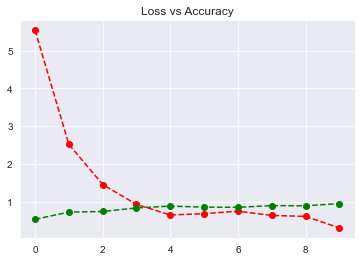

In [68]:
plt.plot(h['loss'],"go--",c="red")
plt.plot(h['accuracy'], "go--",c="green")
plt.title("Loss vs Accuracy")
plt.show()

it's a flip image


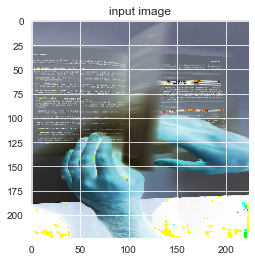

In [82]:
path = './images/testing/flip/0001_000000020.jpg'
# not flip 0008_000000008
img = image.load_img(path, target_size=(224, 224))
i = image.img_to_array(img)
input_arr = np.array([i])
input_arr.shape
pred = np.argmax(model.predict(input_arr))

if pred == 0:
    print("it's a flip image")
else:
    print("it's a notflip image")

plt.imshow((input_arr[0]*255).astype(np.uint8))
plt.title("input image")
plt.show()